In [1]:
# Step 0: Install required libraries (optional on Kaggle, most are pre-installed)
!pip install -q transformers tensorflow scikit-learn nltk

# Step 1: Import libraries
import pandas as pd
import re
import string
import nltk
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import random
import os


2025-08-15 08:44:42.425477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755247482.623932      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755247482.682674      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Step 1a: Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Step 2: Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Step 3: Load dataset (replace path with Kaggle input path)
# e.g., '/kaggle/input/your-dataset/used as train_data (1).csv'
df = pd.read_csv('/kaggle/input/imdb-movie-reviews-dataset/used as train_data (1).csv')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Rename columns
df.columns = ['Reviews', 'Sentiments']

In [4]:
# Step 4: Text cleaning function
def clean_text(text):
    text = re.sub(r'<.*?>', '', str(text))
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)


In [5]:
# Apply cleaning
df['Reviews'] = df['Reviews'].apply(clean_text)

# Step 5: Convert labels to binary
df['Sentiments'] = df['Sentiments'].apply(lambda x: 1 if str(x).lower() == 'positive' else 0)

# Step 6: Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Reviews'].tolist(),
    df['Sentiments'].tolist(),
    test_size=0.2,
    random_state=SEED
)


In [6]:
# Step 7: Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 128  # smaller max length for Kaggle GPU memory

train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_len, return_tensors="tf")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

I0000 00:00:1755247550.279463      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
# Step 8: Convert to TensorFlow datasets
batch_size = 8  # smaller batch size to fit Kaggle GPU
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).shuffle(1000, seed=SEED).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels)).batch(batch_size)

In [8]:
# Step 9: Load DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2, from_pt=False)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [9]:
# Step 10: Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [10]:
# Step 11: Train model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=3)

# Step 12: Training & validation metrics
print("Training Accuracy:", history.history['accuracy'])
print("Validation Accuracy:", history.history['val_accuracy'])
print("Training Loss:", history.history['loss'])
print("Validation Loss:", history.history['val_loss'])


Epoch 1/3


I0000 00:00:1755247588.601831     100 service.cc:148] XLA service 0x7ebce05dfb80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755247588.602417     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755247588.669534     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755247588.786321     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 [==============================] - 255s 91ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 4.6492e-09 - val_accuracy: 1.0000
Epoch 2/3
2500/2500 [==============================] - 209s 83ms/step - loss: 7.5012e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/3
2500/2500 [==============================] - 209s 84ms/step - loss: 2.0891e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Training Accuracy: [0.9996500015258789, 1.0, 1.0]
Validation Accuracy: [1.0, 1.0, 1.0]
Training Loss: [0.001276766648516059, 7.501240872898052e-08, 2.0891416596668932e-08]
Validation Loss: [4.649161944314528e-09, 0.0, 0.0]


In [11]:
# Step 13: Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

625/625 [==============================] - 19s 30ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Test Loss: 0.0000
Test Accuracy: 1.0000


## Model Evaluation

We evaluated the DistilBERT sentiment classifier on the test set using standard metrics:  

- **Accuracy:** Overall percentage of correctly predicted samples.  
- **Precision:** Fraction of relevant positive predictions among all positive predictions.  
- **Recall:** Fraction of correctly predicted positives among all actual positives.  
- **F1-score:** Harmonic mean of precision and recall.  

The classification report below shows the detailed performance for each class (`Negative` and `Positive`):


In [13]:
# Step 14: Classification report
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs.logits, axis=1)
y_true = np.array(test_labels)

# Ensure sklearn sees both classes
labels = [0, 1]  # 0 = Negative, 1 = Positive

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, labels=labels, target_names=['Negative', 'Positive']))


625/625 [==============================] - 19s 30ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      5000
    Positive       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       1.00      1.00      1.00      5000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.

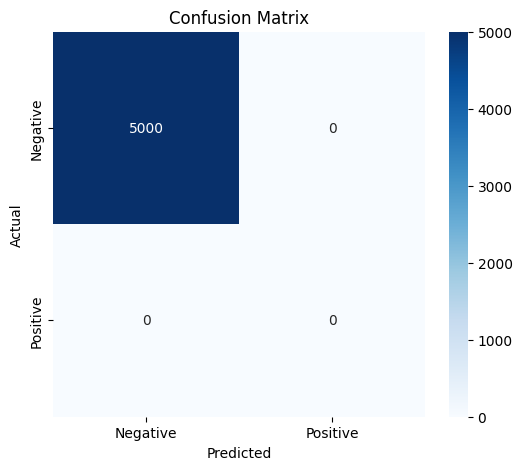

In [14]:
# Step 15: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Display confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Save the trained DistilBERT model
chosen_model = "distilbert_sentiment"

# Save model weights and configuration
model.save_pretrained(f"{chosen_model}_tf_model")

# Save tokenizer
tokenizer.save_pretrained(f"{chosen_model}_tf_model")

print(f"Trained model and tokenizer saved in folder: {chosen_model}_tf_model")


Trained model and tokenizer saved in folder: distilbert_sentiment_tf_model


In [23]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

chosen_model = "distilbert_sentiment"

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(f"{chosen_model}_tf_model")

# Load model
model = TFDistilBertForSequenceClassification.from_pretrained(f"{chosen_model}_tf_model")


Some layers from the model checkpoint at distilbert_sentiment_tf_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert_sentiment_tf_model and are newly initialized: ['dropout_99']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Interactive sentiment prediction loop
label_map = {0: "Negative", 1: "Positive"}

while True:
    # Ask user for input
    user_input = input("Enter a text to analyze sentiment (or type 'n' to exit): ")
    
    if user_input.lower() == 'n':
        print("Exiting the sentiment analyzer. Goodbye!")
        break
    
    # Tokenize input
    encodings = tokenizer([user_input], truncation=True, padding=True, max_length=256, return_tensors="tf")
    
    # Predict
    preds = model(encodings)
    pred_label = tf.argmax(preds.logits, axis=1).numpy()[0]
    
    # Map and print sentiment
    print("Predicted Sentiment:", label_map[pred_label])
    print("-" * 50)


Enter a text to analyze sentiment (or type 'n' to exit):  film absolutely awful nevertheless hilarious times although humor entirely unintentionalthe plot beyond ridiculous dont even think yearold would convinced ludicrous idiocy filmmakers tried slap together story however positive side horrifically inane plot twists provide great deal humor example wow lady hogbottom giant missile hidden back yard gets worse even funnier ill spare youthe acting generally laughable kids roles sort cute believable hand annie pretty awful allaround adults dont take roles seriously largely good thing theyd tried believable film wouldve even worse difficult imagineonce get past overall crappiness movie actually standout moments almostnotcrappiness scene lady hogbottoms son runs away maid surprisingly hilarious though annoying letdown get caught police butler character minor ray sunlight almost never quite pierces gloomwatching movie actually caused physical pain nevertheless redeeming parts made almost wa

Predicted Sentiment: Negative
--------------------------------------------------


Enter a text to analyze sentiment (or type 'n' to exit):  firstly simply funniest movie ever seen incorporates perfectlytimed slapstick sexual humour cleverlythoughtup standup goes deeper souler opposite original love story something dont see often gave hope love therethat two people love work adversity comedic take life something believe accepted people really matter chris meloni gives convincing performance barry singer oscar film brilliantly written hope seeing films everyone involved future


Predicted Sentiment: Negative
--------------------------------------------------


Enter a text to analyze sentiment (or type 'n' to exit):  liked movie remember one well done scene movie riff randell played pj soles lying bed smoking pot begins visualize ramones room sing song want around cool stuffit fun energetic quirky cool yes ill admit ending wayway top far fetched doesnt matter fun fun movie sex pot rock n rocll foreveri read cheap trick band originally star know true


Predicted Sentiment: Negative
--------------------------------------------------


Enter a text to analyze sentiment (or type 'n' to exit):  n


Exiting the sentiment analyzer. Goodbye!
